# Variational quantum eigensolver

In this problem we are building a variational quantum eigensolver (VQE) and use it to find the ground state of a qubit Hamiltonian.

In [66]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import Statevector, SparsePauliOp, state_fidelity
import numpy as np
import numpy.random as npr
import numpy.linalg as linalg
import matplotlib.pyplot as plt

In [67]:
pip install pylatexenc

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


## Hamiltonian

In [68]:
n_qubits = 3
H = SparsePauliOp.from_list([('ZXX', 1), ('XXZ', 0.5), ('YXY', 0.2)])

## Ansatz circuit

Let's use a generic problem-agnostic ansatz circuit with $L$ ''layers''. The number of layers controls the flexibility of the ansatz: higher $L$ circuits can produce more quantum states.

In [69]:
def get_circuit(n, L):
    circ = QuantumCircuit(n)
    params = []
    for i in range(n):
        angle = Parameter(f'$x{i}0$')
        params.append(angle)
        circ.ry(angle, i)
    for l in range(L):
        for i in range(n):
            circ.cx(i, np.mod(i+1, n))
        circ.barrier()
        for i in range(n):
            angle = Parameter(f'$x{i}{l+1}$')
            params.append(angle)
            circ.ry(angle, i)
    return params, circ

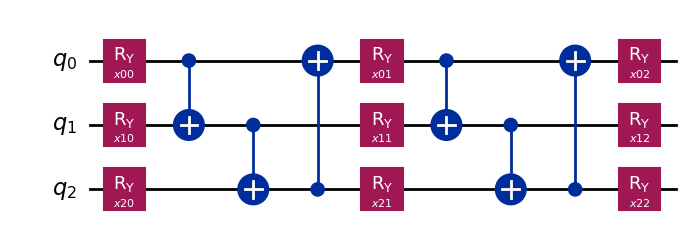

In [70]:
n_layers = 2
params, circ = get_circuit(n_qubits, n_layers)
n_params = len(params)
circ.draw(output="mpl", plot_barriers=False)

## Energy computation

In a real VQE we would use a quantum computer to estimate the energy $E(\theta) = \langle \psi(\theta) | H | \psi(\theta) \rangle$ with a finite number of shots. This would produce some amount of shot noise in the energy estimation. For the purposes of this exercise we will simplify life by computing $E(\theta)$ directly, thus removing any noise effects.

In [71]:
def energy(param_values):
    '''
    Computes the energy of `H` in the state produced by `circ`.
    
    Arguments:
    param_values: an array of length `len(params)` representing circuit parameter values.

    Returns:
    The energy for the given `param_values` (float).
    '''

    if len(param_values) != len(params):
        print('The length of param_values must be', len(params))
        return

    binds = {p: v for p, v in zip(params, param_values)}
    state = Statevector.from_instruction(circ.assign_parameters(binds))
    E = state.expectation_value(H).real
    return E

Example usage:

In [72]:
test_values = npr.uniform(0, 2*np.pi, len(params))
print('Energy for parameter values', test_values, 'is', energy(test_values))

Energy for parameter values [2.21296226 1.58743005 3.20433651 1.49923844 4.96770447 0.63533109
 1.1200783  5.46202114 5.12605734] is -0.0660791637273874


## Gradient calculation

In order to use gradient-based optimization methods such as gradient descent, we need to be able to find gradients of $E(\theta)$ w.r.t. the parameters $\theta$.

Fill in the following function that implements the parameter-shift rule. You can use the `energy`-function in your implementation.

In [73]:
def gradient(param_values):
    '''
    Computes the gradient of the energy w.r.t. the parameters.
    
    Arguments:
    param_values: an array of length `len(params)` representing circuit parameter values.
    
    Returns:
    The components of the energy gradient (array).
    '''
    from functools import reduce

    if len(param_values) != len(params):
        print('The length of param_values must be', len(params))
        return
    return np.array([0.5*(energy(reduce(lambda a,b:a+[b+np.pi/2] if b == x else a+[b],param_values,[])) - energy(reduce(lambda a,b:a+[b-np.pi/2] if b == x else a+[b],param_values,[]))) for x in param_values])

## Optimization

We will use a simple gradient descent algorithm for optimization. That is, we update the parameters
$$
\theta \leftarrow \theta - \epsilon \nabla E(\theta)
$$
until the energy $E(\theta)$ reaches a minimum. The step size $\epsilon$ is often called the ''learning rate''.

In [74]:
def gradient_descent(steps=100, lr=0.1):
    x = npr.uniform(0, 2*np.pi, n_params)
    ergs = [energy(x)]
    for i in range(steps):
        x -= lr*gradient(x)
        ergs.append(energy(x))
    return ergs, x

## Results

Now run the simple gradient descent algorithm. Can you find the ground state energy? If you have trouble with convergence in `gradient_descent` you might need to fiddle with `steps` and `lr`.

Final optimization energy is -1.6750112893904505


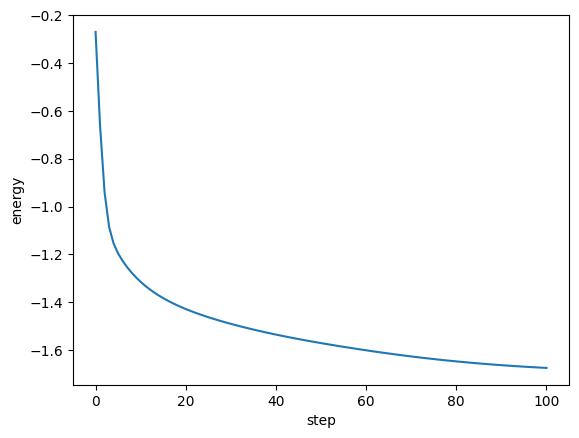

In [75]:
ergs, final_values = gradient_descent(steps=100, lr=0.1)
print('Final optimization energy is', ergs[-1])
plt.plot(ergs)
plt.xlabel('step')
plt.ylabel('energy');

How close did you get to the true ground state energy, which is

In [76]:
eigenvalues, eigenvectors = linalg.eigh(H.to_matrix())
print('Ground state energy is', eigenvalues[0])
print('Ground state is', eigenvectors[:, 0])
final_state_vector = Statevector.from_instruction(circ.assign_parameters({p: v for p, v in zip(params, final_values)})).data
print('Fidelity of final state with ground state is', state_fidelity(final_state_vector, eigenvectors[:, 0]))

Ground state energy is -1.7
Ground state is [-0.35355339+0.j -0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
 -0.35355339+0.j  0.35355339+0.j  0.35355339+0.j -0.35355339+0.j]
Fidelity of final state with ground state is 0.9382925089083982


: 